# **Correlation Analysis**

In [1]:
# mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.signal as signal
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import cmocean.cm as cmo

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# Python Correlation Functions

**Documentation:**
* [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html)
* [scipy.signal.correlate](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate)
* [scipy.signal.correlation_lags](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlation_lags.html#scipy.signal.correlation_lags)
* [matplotlib.pyplot.xcorr](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xcorr.html)

**Helpful Resources:**
* [Wikipedia - Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_stochastic_processes)
* [Wikipedia - Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
* [Why are the results of R's ccf and SciPy's correlate different?](https://stats.stackexchange.com/questions/339782/why-are-the-results-of-rs-ccf-and-scipys-correlate-different/353408)
* [How do I get R's ccf in Python?](https://stackoverflow.com/questions/53959879/how-do-i-get-rs-ccf-in-python)
* [How to interpret the values returned by numpy.correlate and numpy.corrcoef?](https://stackoverflow.com/questions/13439718/how-to-interpret-the-values-returned-by-numpy-correlate-and-numpy-corrcoef)
* [**Oceanography Correlation Analysis**](https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html)
* [Penn State - Cross Correlation Functions and Lagged Regressions](https://online.stat.psu.edu/stat510/lesson/8/8.2)
* [Deterministic Skill Scores](https://metclim.ucd.ie/wp-content/uploads/2017/07/DeterministicSkillScore.pdf)

## `signal.correlate` and `np.correlate`

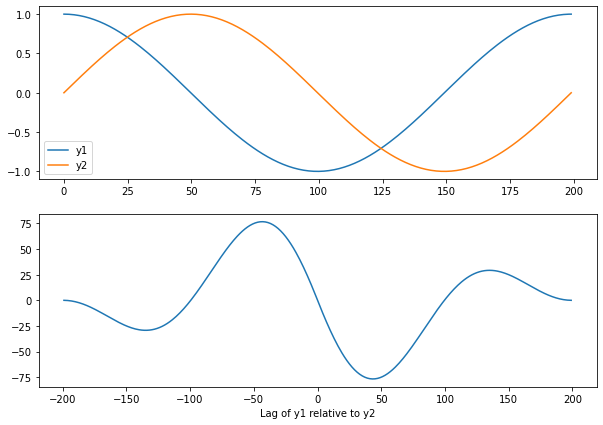

In [3]:
y1 = np.cos(np.linspace(0,np.pi*2,200))
y2 = np.sin(np.linspace(0,np.pi*2,200))

mode = 'full'
signal_corr = signal.correlate(y1, y2, mode=mode)
signal_lags = signal.correlation_lags(y1.size, y2.size, mode=mode)

fig, (ax_signals, ax_corr) = plt.subplots(2, 1, figsize=(10,7))

ax_signals.plot(y1, label='y1')
ax_signals.plot(y2, label='y2')
ax_signals.legend()

ax_corr.plot(signal_lags, signal_corr)

xlim = ax_corr.get_xlim()

ax_corr.set_xlabel('Lag of y1 relative to y2');

In the plot above, `y1` leads `y2` (alternatively `y2` lags `y1`) which is shown by the peak in correlation at around lag = 50.

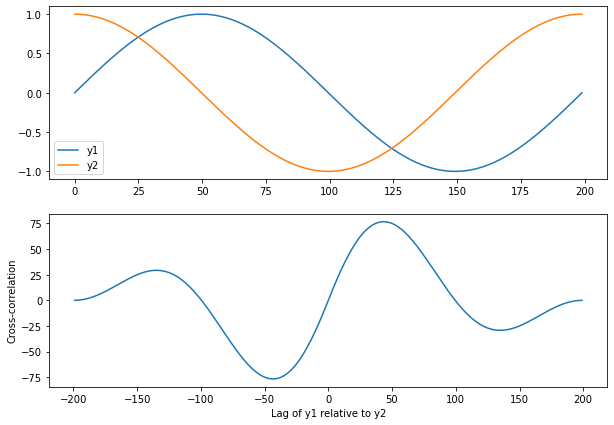

In [4]:
y1 = np.sin(np.linspace(0,np.pi*2,200))
y2 = np.cos(np.linspace(0,np.pi*2,200))

mode = 'full'
signal_corr = signal.correlate(y1, y2, mode=mode)
signal_lags = signal.correlation_lags(y1.size, y2.size, mode=mode)

fig, (ax_signals, ax_corr) = plt.subplots(2, 1, figsize=(10,7))

ax_signals.plot(y1, label='y1')
ax_signals.plot(y2, label='y2')
ax_signals.legend()

ax_corr.plot(signal_lags, signal_corr)

xlim = ax_corr.get_xlim()

ax_corr.set_xlabel('Lag of y1 relative to y2');
ax_corr.set_ylabel('Cross-correlation');

In the plot above, `y1` lags `y2` (alternatively `y2` leads `y1`) which is shown by the peak in correlation at around lag = 50.

In [5]:
False in (signal_lags == np.arange(-199,200))

False

In [6]:
## signal.correlate and np.correlate(mode='full') return the same arrays
## signal.correlate is faster for larger arrays
print('Different values from signal.correlate and np.correlate?')
print(False in (signal.correlate(y1, y2, mode='full') == np.correlate(y1, y2, mode='full')))

Different values from signal.correlate and np.correlate?
False


## `plt.xcorr`
It looks like `xcorr(normed=True)*100` $\approx$ `xcorr(normed=False)`

max = 230.17183623055953
argmax = 242
size = 399

max = 0.7672490447748668
argmax = 242
size = 399

(-218.9, 218.9)


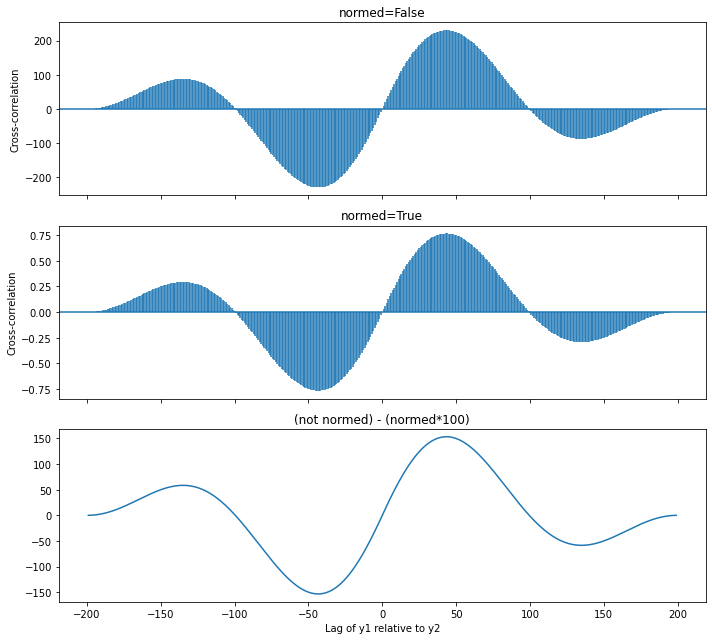

In [7]:
y1 = np.sin(np.linspace(0,np.pi*2,200)) * 3
y2 = np.cos(np.linspace(0,np.pi*2,200))

## matplotlib version of xcorr() which uses numpy.correlate(mode='full')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,9))

maxlags = len(y1)-1

xcorr = ax1.xcorr(y1, y2, maxlags=maxlags, normed=False)
xcorr_normed = ax2.xcorr(y1, y2, maxlags=maxlags, normed=True)
ax3.plot(np.arange(-199,200), xcorr[1] - (xcorr_normed[1]*100))

ax1.set_title('normed=False')
ax2.set_title('normed=True')
ax3.set_title('(not normed) - (normed*100)')

ax1.set_ylabel('Cross-correlation');
ax2.set_ylabel('Cross-correlation');

ax3.set_xlabel('Lag of y1 relative to y2');

fig.tight_layout()

for arr in [xcorr[1], xcorr_normed[1]]:
    print('max = '+str(arr.max()))
    print('argmax = '+str(np.argmax(arr)))
    print('size = '+str(arr.size))
    print()
    
print(ax1.get_xlim())

# My Functions

In [8]:
def open_metric(
    var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

In [9]:
def xcorr(y1, y2, max_lag=None, direction=None, normed=True):
    assert len(y1) == len(y2)
    size = len(y1)
    
    if max_lag != None:
        assert max_lag <= len(y1)
    if max_lag == None:
        max_lag = size
        
    lo = size - max_lag
    hi = size + (max_lag - 1)
    
    if direction == 'lead':
        hi = size
    if direction == 'lag':
        lo = size-1
        
    mode = 'full'
    method = 'auto'
        
    if not normed:
        lags = signal.correlation_lags(len(y1), len(y2), mode=mode)
        xcorr = signal.correlate(y1, y2, mode=mode, method=method)   
        return xcorr[lo:hi], lags[lo:hi]
    
    if normed:
        lags = signal.correlation_lags(len(y1), len(y2), mode=mode)
        xcov = signal.correlate(y1 - np.mean(y1), y2 - np.mean(y2), mode=mode, method=method)   
        xcorr = xcov / (y1.std() * y2.std() * size)
        return xcorr[lo:hi], lags[lo:hi]

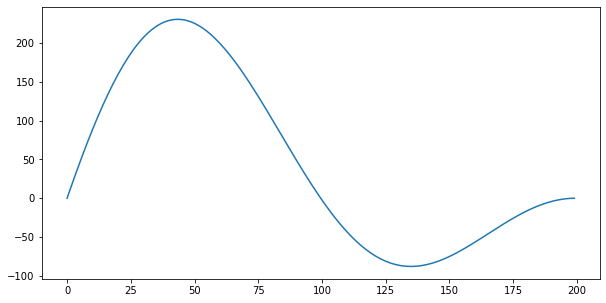

In [10]:
xcorr_arr, lags = xcorr(y1, y2, normed=False, max_lag=200, direction='lag')

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(lags, xcorr_arr)

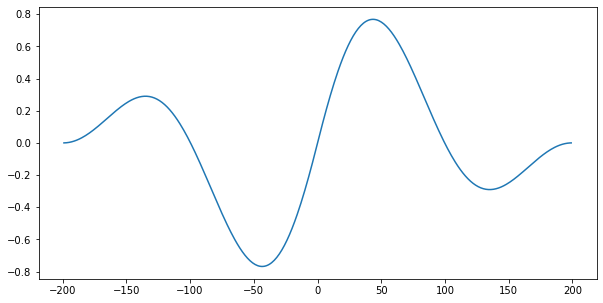

In [11]:
xcorr_normed_arr, lags = xcorr(y1, y2, normed=True)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(lags, xcorr_normed_arr)

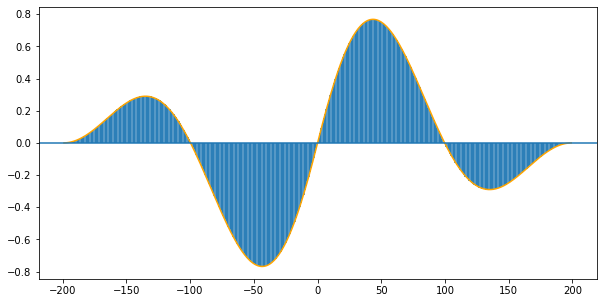

In [12]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(lags, xcorr_normed_arr, color='orange')

ax.xcorr(y1, y2, maxlags=len(y1)-1);

Slight difference between `plt.xcorr` and the normalized `signal.correlate`. I don't think it's a big deal, so I'm going to stick with the normalized `signal.correlate` because I have a better understanding of what exactly it is doing.

In [13]:
def comp_xcorr(
    target_var, other_vars, reg, metric, max_lag=24, normed=True):

    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']

    if reg.lower() == 'global':
        reg = 'Global'
        subreg = 'global'

    if reg.lower() != 'global' and reg.lower() != 'all':
        subreg = 'so'

    target_metric = open_metric(target_var, subreg, metric, timescale='monthly')
    xcorr_matrix = np.zeros((len(other_vars), max_lag))
    var_names = []

    for (i,var) in zip(range(max_lag), other_vars):
        other_metric = open_metric(var, subreg, metric, timescale='monthly')

#         ## the other metric lags the target metric = the target metric leads the other metric
#         xcorr = xcorr(other_metric[reg], target_metric[reg], max_lag=max_lag, direction='lag', normed=True)

        ## the target metric lags the other metric = the other metric leads the target metric
        xcorr_arr, lag_arr = xcorr(target_metric[reg].values, other_metric[reg].values, max_lag=max_lag, direction='lag', normed=normed)

        xcorr_matrix[i] = xcorr_arr

        var_names.append(var_su_names[var])
    
    return xcorr_matrix.T, var_names

In [14]:
def xcorr_heatmap(
    target_var, other_vars, reg, metric, max_lag=24, normed=True, yaxis_steps=2, cmap=cmo.balance, figsize=(6,6)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    xcorr_matrix, var_names = comp_xcorr(target_var, other_vars, reg, metric, max_lag=max_lag, normed=normed)

    fig,ax = plt.subplots(sharex=True, sharey=True, figsize=figsize)

    im = ax.pcolormesh(xcorr_matrix, vmin=-1, vmax=1, cmap=cmap, shading='auto')

    ax.set_yticks(np.arange(0, xcorr_matrix.shape[0], yaxis_steps) + 0.5)
    mult = int(max_lag/12)+1
    ax.set_yticklabels((abbrv_month_names*mult)[0:max_lag:yaxis_steps])
    ax.set_ylabel('Lead time $\longrightarrow$')

    ax.set_xticks(np.arange(xcorr_matrix.shape[1]) + 0.5)
    ax.set_xticklabels(var_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fig.suptitle(reg_names[reg]+' - XCORR - '+metric.upper())
    fig.tight_layout()

    cb = fig.colorbar(im, label='Correlation to NPP')
    
    return fig,ax

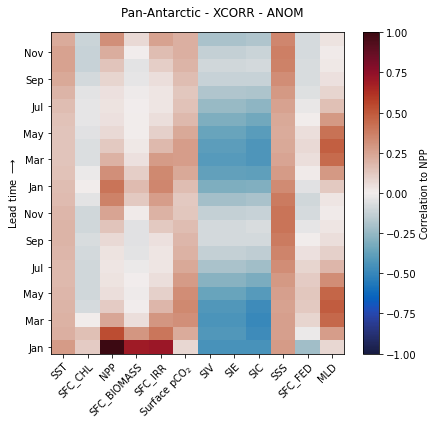

In [15]:
variables = ['sst', 'sfc_chl', 'npp', 'sfc_biomass', 'sfc_irr', 'pco2surf', 'siv', 'sie', 'cn_inv', 'sss', 'sfc_fed', 'mld']
xcorr_heatmap('npp', variables, 'SouthernOcean', 'anom', max_lag=24);

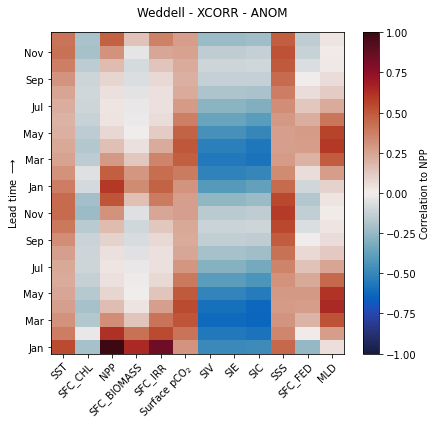

In [16]:
variables = ['sst', 'sfc_chl', 'npp', 'sfc_biomass', 'sfc_irr', 'pco2surf', 'siv', 'sie', 'cn_inv', 'sss', 'sfc_fed', 'mld']
xcorr_heatmap('npp', variables, 'Weddell', 'anom', max_lag=24);

(-24.0, 24.0)

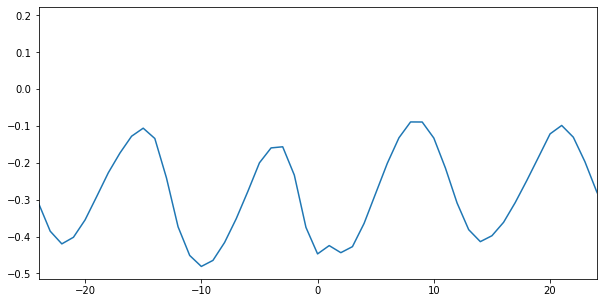

In [17]:
fig,ax = plt.subplots(figsize=(10,5))

values, lags = xcorr(open_metric('npp', 'so', 'anom')['SouthernOcean'].values, open_metric('sie', 'so', 'anom')['SouthernOcean'].values)
ax.plot(lags, values)
ax.set_xlim(-24,24)